In [2]:
using CSV
using DataFrames
using Gadfly
using Colors
using Indicators

In [3]:
import Cairo
import Fontconfig

In [11]:
Gadfly.set_default_plot_size(800px, 600px)

In [16]:
traces_filenames = [
"riak.baseline.c1.2021-04-13T17-28-14Z.log",
"riak.baseline.c5.2021-04-13T17-29-39Z.log",
"riak.baseline.c25.2021-04-13T17-31-01Z.log"
]
traces_frames = map(traces_filenames) do fn
    CSV.File(fn; delim="\t", header=[:run, :ts, :class, :id, :event, :evdata]) |> DataFrame
end
traces = vcat(traces_frames...)
describe(traces)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,run,,riak.baseline.c1,,riak.baseline.c5,0,String
2,ts,35.5021,5.0e-6,35.418,79.6221,0,Float64
3,class,,beat,,loadgen,0,String
4,id,,1,,warmup,0,String
5,event,,finished,,worker start,0,String
6,evdata,,0.999000999000999,,{},0,String


In [17]:
traces_client = select(
    filter(x -> x.class == "client" && !contains(x.id, "warmup"), traces),
    :run, :id, :ts, :event
)
traces_client_grouped = groupby(traces_client, [:run, :id])
timings_client = combine(
    traces_client_grouped,
    :ts => (x -> diff(x) * 1000) => :init,
    :ts => minimum => :ts
)
first(timings_client, 8)

,run,id,init,ts
,String,String,Float64,Float64
1,riak.baseline.c1,9gfa0C/1/1,4.734,4.99904
2,riak.baseline.c1,9gfa4N/1/2,5.416,5.25894
3,riak.baseline.c1,9gfa8E/1/3,4.748,5.49732
4,riak.baseline.c1,9gfaC9/1/4,5.575,5.74034
5,riak.baseline.c1,9gfaGI/1/5,4.71,5.99797
6,riak.baseline.c1,9gfaK7/1/6,6.107,6.2342
7,riak.baseline.c1,9gfaOL/1/7,4.656,6.49636
8,riak.baseline.c1,9gfaSG/1/8,5.594,6.73928


In [18]:
bucket_size = 5
timings_client_buckets = transform(
    timings_client,
    :ts => (x -> trunc.(Int, x / bucket_size) * bucket_size) => :bucket
)
first(timings_client_buckets, 8)

,run,id,init,ts,bucket
,String,String,Float64,Float64,Int64
1,riak.baseline.c1,9gfa0C/1/1,4.734,4.99904,0
2,riak.baseline.c1,9gfa4N/1/2,5.416,5.25894,5
3,riak.baseline.c1,9gfa8E/1/3,4.748,5.49732,5
4,riak.baseline.c1,9gfaC9/1/4,5.575,5.74034,5
5,riak.baseline.c1,9gfaGI/1/5,4.71,5.99797,5
6,riak.baseline.c1,9gfaK7/1/6,6.107,6.2342,5
7,riak.baseline.c1,9gfaOL/1/7,4.656,6.49636,5
8,riak.baseline.c1,9gfaSG/1/8,5.594,6.73928,5


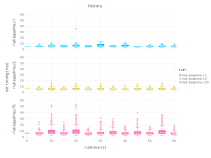

In [23]:
hstack(
    Gadfly.plot(
        timings_client_buckets,
        ygroup=:run, color=:run,
        Geom.subplot_grid(
            layer(x=:bucket, y=:init, Geom.boxplot)
#             layer(Stat.smooth(method=:loess, smoothing=0.5), Geom.line),
#             layer(Geom.point, shape=[Shape.square], alpha=[0.25]),
#             free_y_axis=true
        ),
        Guide.xlabel("runtime (s)"), Guide.ylabel("init timing (ms)"),
        Guide.title("History"),
        style(point_size=2pt, boxplot_spacing=16pt)
    )
) |> SVG()

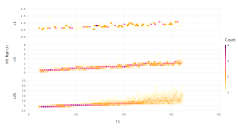

In [361]:
Gadfly.plot(
    timings_client,
    x=:ts, y=:init, ygroup=:run,
    Scale.color_continuous(colormap=Scale.lab_gradient("lightyellow", "orange", "hotpink", "purple")),
    Geom.subplot_grid(
        Geom.hexbin(xbincount=120, ybincount=20),
        free_y_axis=true
    )
) |> SVG()

In [24]:
inits_per_sec = combine(
    groupby(
        select(
            filter(x -> x.event == "init started", traces_client),
            :run,
            :ts,
            :ts => (x -> trunc.(Int, x)) => :bucket
        ),
        [:run, :bucket]
    ),
    nrow
)
first(inits_per_sec, 8)

,run,bucket,nrow
,String,Int64,Int64
1,riak.baseline.c1,4,1
2,riak.baseline.c1,5,4
3,riak.baseline.c1,6,4
4,riak.baseline.c1,7,3
5,riak.baseline.c1,8,4
6,riak.baseline.c1,9,4
7,riak.baseline.c1,10,5
8,riak.baseline.c1,11,4


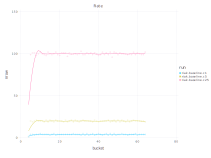

In [25]:
Gadfly.plot(
    inits_per_sec,
    x=:bucket, y=:nrow, color=:run,
    layer(Stat.smooth(method=:loess, smoothing=0.25), Geom.line),
    layer(Geom.point, shape=[Shape.cross], size=[2pt], alpha=[0.5]),
    Guide.title("Rate")
) |> SVG()